<a href="https://colab.research.google.com/github/ksk94966/XNN_Math/blob/master/NN_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch Number  1
-------------------------------start--------------------------------


Time Elapsed --->      332.46087408065796
Average Training Loss for this epoch -->    35.566742007804066
Average Testing Loss for this epoch -->    2.16124478647981
Testing Accuracy for this epoch--->    19.55


---------------------End---------------------------------------


-----------------Displaying each labels final Accuracies after all epochs-----------------------------------


Label   0   Accuracy -->   0.0
Label   1   Accuracy -->   0.6599118942731278
Label   2   Accuracy -->   0.6957364341085271
Label   3   Accuracy -->   0.0
Label   4   Accuracy -->   0.0
Label   5   Accuracy -->   0.0
Label   6   Accuracy -->   0.5093945720250522
Label   7   Accuracy -->   0.0
Label   8   Accuracy -->   0.0
Label   9   Accuracy -->   0.0




Testing Accuracy vs Epoch




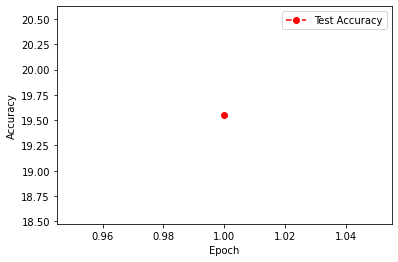



Testing Accuracy ----  TrainingAccuracy        vs        Epoch




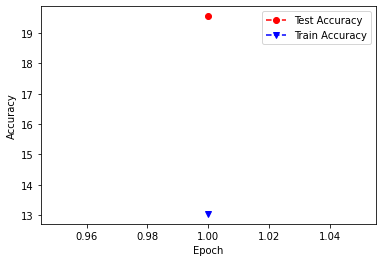



Testing Loss  --  Training Loss  vs     Epoch




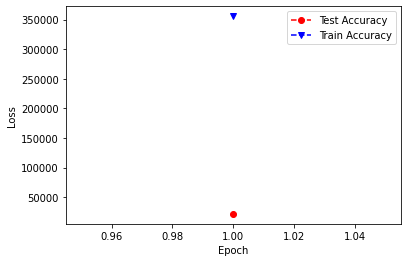

Total time Taken for the entire Program : --->   337.51618456840515


--------------------------------------Layer Info----------------------------------------------------------------------------------------------


Division                          -->        1 * 28 * 28      -->        1 * 28 * 28        -->       None                 -->      28*28 
Vectorization                -->        1 * 28 * 28      -->        1 * 784               -->       None                 -->      None 
Matrix multiplication  -->        1 * 784             -->        1 * 1000            -->       784 * 1000       -->      784*1000 
Addition                        -->        1 * 1000           -->        1 * 1000            -->       1 * 1000            -->      1000 
ReLU                              -->        1 * 1000           -->        1 * 1000            -->       None                  -->      1000 
Matrix multiplication  -->        1 * 1000           -->        1 * 100              -->       1000

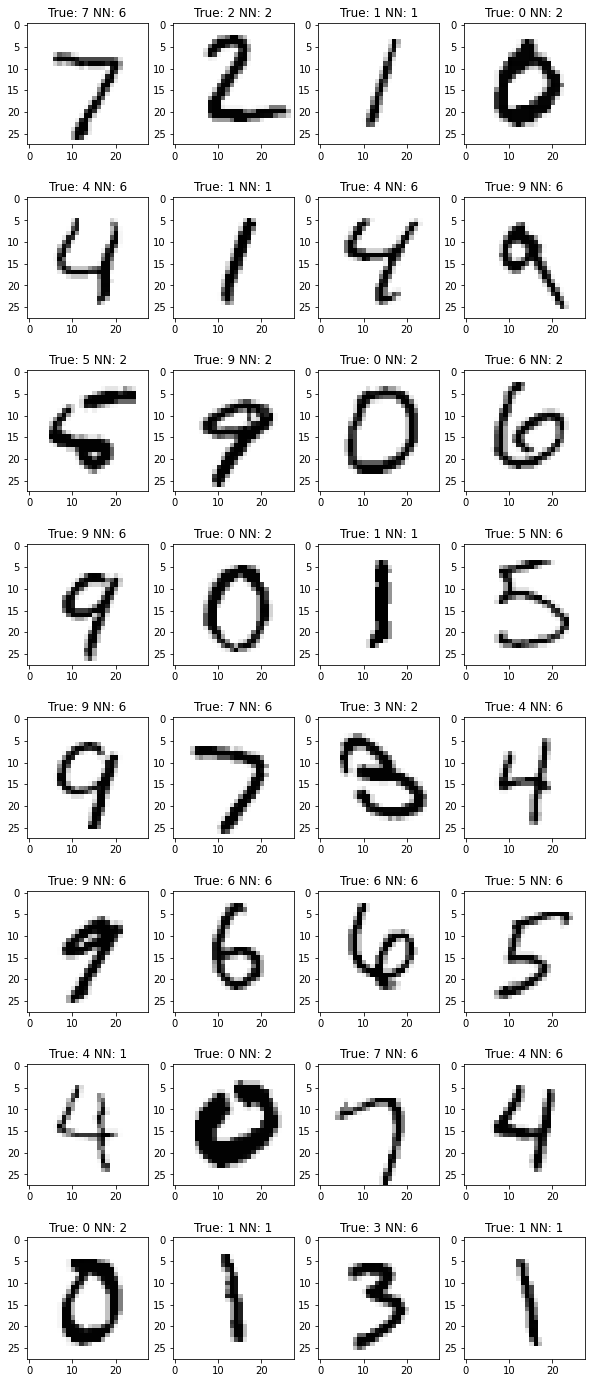

In [4]:
import os.path
import urllib.request
import gzip
import math
import numpy  as np
import matplotlib.pyplot as plt
import time                                                         #for calculating the total time for the program

start_prgm_time = time.time()

Number_of_epochs  = 1                                #can change the total number of epochs over here

# data
DATA_NUM_TRAIN         = 60000
DATA_NUM_TEST          = 10000
DATA_CHANNELS          = 1
DATA_ROWS              = 28
DATA_COLS              = 28
DATA_CLASSES           = 10
DATA_URL_TRAIN_DATA    = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
DATA_URL_TRAIN_LABELS  = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
DATA_URL_TEST_DATA     = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
DATA_URL_TEST_LABELS   = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
DATA_FILE_TRAIN_DATA   = 'train_data.gz'
DATA_FILE_TRAIN_LABELS = 'train_labels.gz'
DATA_FILE_TEST_DATA    = 'test_data.gz'
DATA_FILE_TEST_LABELS  = 'test_labels.gz'

# display
DISPLAY_ROWS   = 8
DISPLAY_COLS   = 4
DISPLAY_COL_IN = 10
DISPLAY_ROW_IN = 25
DISPLAY_NUM    = DISPLAY_ROWS*DISPLAY_COLS

# download
if (os.path.exists(DATA_FILE_TRAIN_DATA)   == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_DATA,   DATA_FILE_TRAIN_DATA)
if (os.path.exists(DATA_FILE_TRAIN_LABELS) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_LABELS, DATA_FILE_TRAIN_LABELS)
if (os.path.exists(DATA_FILE_TEST_DATA)    == False):
    urllib.request.urlretrieve(DATA_URL_TEST_DATA,    DATA_FILE_TEST_DATA)
if (os.path.exists(DATA_FILE_TEST_LABELS)  == False):
    urllib.request.urlretrieve(DATA_URL_TEST_LABELS,  DATA_FILE_TEST_LABELS)

# training data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_train_data   = gzip.open(DATA_FILE_TRAIN_DATA, 'r')
file_train_data.read(16)
buffer_train_data = file_train_data.read(DATA_NUM_TRAIN*DATA_ROWS*DATA_COLS)
train_data        = np.frombuffer(buffer_train_data, dtype=np.uint8).astype(np.float32)
train_data        = train_data.reshape(DATA_NUM_TRAIN, 1, DATA_ROWS, DATA_COLS)

# training labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_train_labels   = gzip.open(DATA_FILE_TRAIN_LABELS, 'r')
file_train_labels.read(8)
buffer_train_labels = file_train_labels.read(DATA_NUM_TRAIN)
train_labels        = np.frombuffer(buffer_train_labels, dtype=np.uint8).astype(np.int32)

# testing data
# unzip the file, skip the header, read the rest into a buffer and format to NCHW
file_test_data   = gzip.open(DATA_FILE_TEST_DATA, 'r')
file_test_data.read(16)
buffer_test_data = file_test_data.read(DATA_NUM_TEST*DATA_ROWS*DATA_COLS)
test_data        = np.frombuffer(buffer_test_data, dtype=np.uint8).astype(np.float32)
test_data        = test_data.reshape(DATA_NUM_TEST, 1, DATA_ROWS, DATA_COLS)

# testing labels
# unzip the file, skip the header, read the rest into a buffer and format to a vector
file_test_labels   = gzip.open(DATA_FILE_TEST_LABELS, 'r')
file_test_labels.read(8)
buffer_test_labels = file_test_labels.read(DATA_NUM_TEST)
test_labels        = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int32)

#Printing dimensions
# print(train_data.shape)   # (60000, 1, 28, 28)
# print(train_labels.shape) # (60000,)
# print(test_data.shape)    # (10000, 1, 28, 28)
# print(test_labels.shape)  # (10000,)

#hidden Layer1
wh1 = np.random.rand(784,1000)/np.sqrt(784)
bh1 = np.random.rand(1,1000)

#hidden Layer2
wh2 = np.random.rand(1000,100)/np.sqrt(1000)
bh2 = np.random.rand(1,100)

#Output Layer
wo = np.random.rand(100,10)/np.sqrt(100)
bo = np.random.rand(1,10)

#Helper functions
def multi1(v):
  return np.dot(v,wh1)

def multi2(v):
  return np.dot(v,wh2)

def multi3(v):
  return np.dot(v,wo)

def ReLU(x):
  return np.maximum(0,x)

def reluDerivative(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x /np.sum(e_x)

def getLabelMatrix(i):
  lab = np.zeros((1,10))
  lab[0][i] = 1
  return lab



epoch_test_accuracy = dict()                                                      #For storing epoch testing accuracies for the respective epochs
accuracy_label_encountered = dict()                               #For storing the respective label count encountered
accuracy_label_correct = dict()                                         #For storing the correctly predicted respective label count 

for i in range(10):                                                                  #to
  accuracy_label_encountered[i] = 0       

for i in range(10):
  accuracy_label_correct[i] = 0

lr = 0.001                    # Learning Rate

test_data =  (test_data/255).astype('float32')


#------------------------------------------------------------------------testing function---------------------------------------------------------------------------------#

def testingNN(testdata,testlabels):
  count = 0;
  total = 0; 
#Forward Pass
  total_testing_loss = 0
  for sample in range(10000):
    a0 = testdata[sample]                                                                    #division by 255
    a0 = a0.reshape(1,784)                                                                 #Reshaping ---> Vectorization
    #print(bh1)

    #Passing the sample through first hidden layer
    zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
    ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
    # print(ah1)

    #passing the h1 sample through second hiddden layer
    zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
    ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
    

    #passing the h2 sample through third hiddden layer
    zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
    ao = softmax(zo)                                                                                             #Generated output Activations
    #print(ao)

    pred = np.argmax(ao)

    #print(pred)

    y = getLabelMatrix(testlabels[sample])                          #desired output label

    accuracy_label_encountered[testlabels[sample]] += 1
    #print(y)

    if(y[0][pred]):
      count += 1
      accuracy_label_correct[pred] += 1 
    
    total += 1

  #print((count/total)*100)

    testing_loss = np.sum(-y * np.log(ao))
    total_testing_loss += testing_loss

  return (count/total)*100,total_testing_loss

#-------------------------------------------------------------------------------------Training---------------------------------------------------------------------------------------------------------

# accuracy_label_train_encountered = dict()                               #For storing the respective train label count encountered
# accuracy_label_train_correct = dict()                                         #For storing the correctly predicted respective train label count 

# for i in range(10):                                                                  
#   accuracy_label_train_encountered[i] = 0       

# for i in range(10):
#   accuracy_label_train_correct[i] = 0

epoch_train_accuracy = dict()

epoch_train_loss = dict()
epoch_test_loss = dict()

train_data =  (train_data/255).astype('float32')

batch_size = 20

#Training epochs 
for epoch in range(Number_of_epochs):                                                              #No of epochs
  epoch_number = epoch + 1
  start = time.time()
  train_LossPerEpoch = 0
  count = 0;
  total = 0; 
  #Training Forward Pass
  batch = 0
  dcost_dw1 =0 
  dcost_db1 = 0
  dcost_dw2 =0
  dcost_db2 = 0
  dcost_dwf =0
  dcost_dbf = 0
  for sample in range(60000):

    batch += 1

    a0 = np.copy(train_data[sample])                                               
    a0 = a0.reshape(1,784)                                                                                #Reshaping ---> Vectorization
    #print(bh1)

    #Passing the sample through first hidden layer
    zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
    ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
    # print(ah1)

    #passing the h1 sample through second hiddden layer
    zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
    ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
    
    #passing the sample to get output
    zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
    ao = softmax(zo)                                                                                             #Generated output Activations
    #print(ao)

    pred = np.argmax(ao)

    y = getLabelMatrix(train_labels[sample])                                              #desired output label

    # accuracy_label_train_encountered[testlabels[sample]] += 1
    # #print(y)

    if(y[0][pred]):
      count += 1
      # accuracy_label_train_correct[pred] += 1 
    
    total += 1

    #Here we are using entropy function as loss function
    #BackPropagation----------------------------------------------------------

    #phase 1              ---> for the output layer
    dcost_dzo = ao - y                                                                             #(1,10)
    dzo_dwo = ah2.transpose()                                                            #(1,100)   --> we have to transpose this one
    dcost_dwo = np.dot( dzo_dwo,dcost_dzo)                                 #derivate of cost w.r.t output weights      #(100,10)
    dcost_dbo = dcost_dzo                                                                   #derivative of cost w.r.t bias                      #(1,10)

    #phase 2              ---> for the hidden layer 2 
    dzo_dah2 = wo
    dcost_dah2 = np.dot(dcost_dzo , dzo_dah2.transpose())
    dah2_dzh2 = reluDerivative(zh2)
    dzh2_dwh2 = ah1
    dcost_dwh2 = np.dot(dzh2_dwh2.T,dah2_dzh2*dcost_dah2)
    dcost_dbh2 = dcost_dah2 * dah2_dzh2
    #print(dcost_dwh2)

    #phase 3   ---- > for hidden layer 1
    dzh2_dah1 = wh2
    dcost_dzh2 = dcost_dah2 * dah2_dzh2
    dcost_dah1 = np.dot(dcost_dzh2,dzh2_dah1.transpose()) 
    dah1_dzh1 = reluDerivative(zh1)
    dzh1_dwh1 = a0
    dcost_dwh1 = np.dot(dzh1_dwh1.T,dah1_dzh1 *dcost_dah1)
    dcost_dbh1 = dcost_dah1 * dah1_dzh1
    #print(dzh1_dwh1)
    
    #batch wise processing
    if (batch!=0 and batch%batch_size==0):
      wh1 -= lr * (dcost_dw1/batch_size)                                                                    #reducing the weights
      bh1 -= lr * ((dcost_db1.sum(axis=0))/batch_size)
      wh2 -= lr * (dcost_dw2/batch_size)
      bh2 -= lr * ((dcost_db2.sum(axis=0))/batch_size)
      wo -= lr * (dcost_dwf/batch_size)
      bo -= lr * ((dcost_dbf.sum(axis=0))/batch_size)
      dcost_dw1 =0 
      dcost_db1 = 0
      dcost_dw2 =0
      dcost_db2 = 0
      dcost_dwf =0
      dcost_dbf = 0
    else:
      dcost_dw1 += dcost_dwh1
      dcost_db1 += dcost_dbh1
      dcost_dw2 += dcost_dwh2
      dcost_db2 += dcost_dbh2
      dcost_dwf += dcost_dwo
      dcost_dbf += dcost_dbo

    
    loss = np.sum(-y * np.log(ao))                                        #loss calculation
    train_LossPerEpoch += loss
    #print('Loss function value: ', loss)
  training_accuracy_perEachEpoch = (count/total)*100
  epoch_train_accuracy[epoch_number] = training_accuracy_perEachEpoch
  end = time.time()
  time_elapsed = end - start
  print("Epoch Number ", epoch_number)
  print("-------------------------------start--------------------------------")
  print("\n")
  print("Time Elapsed --->     ", time_elapsed )
  epoch_train_loss[epoch_number] = train_LossPerEpoch
  Avg_train_LossPerEpoch = train_LossPerEpoch/10000
  print("Average Training Loss for this epoch -->   " , Avg_train_LossPerEpoch)
  test_accuracy_epoch,test_LossPerEpoch =  testingNN(test_data,test_labels)
  print("Average Testing Loss for this epoch -->   " , test_LossPerEpoch/10000)
  epoch_test_loss[epoch_number] = test_LossPerEpoch
  print("Testing Accuracy for this epoch--->   ", test_accuracy_epoch)
  print("\n")
  print("---------------------End---------------------------------------")
  print("\n")
  epoch_test_accuracy[epoch_number] = test_accuracy_epoch                                    #Storing the testing accuracy for each epoch to print the plot later at the end
  


#--------------------------------------------------------------------------------------Overall  Accuracy Display for each label------------------------------------------------- 

accuracy_display = dict()                                                                           #For storing epoch label accuracies for each respective label
for i in range(10):
    if(accuracy_label_encountered[i]!=0):
      accuracy_display[i]  = accuracy_label_correct[i]/accuracy_label_encountered[i]
    else:
      accuracy_display[i] = 0  

print("-----------------Displaying each labels final Accuracies after all epochs-----------------------------------")
print("\n")

for k in accuracy_display:
  print("Label  ",k,"  Accuracy -->  ", accuracy_display[k] )

print("\n")

#print(accuracy_display)
#final Value
#plotting

epoch_train_count = []                                                                          #Helper array
epoch_trainAccuracy = []                                                             #Helper array
for key in epoch_train_accuracy:                                                        #Storing all the accuracy values in the arrays to display a plot  
  epoch_train_count.append(key)
  epoch_trainAccuracy.append(epoch_train_accuracy[key])

epoch_count = []                                                                          #Helper array
epoch_testAccuracy = []                                                             #Helper array
for key in epoch_test_accuracy:                                                        #Storing all the accuracy values in the arrays to display a plot  
  epoch_count.append(key)
  epoch_testAccuracy.append(epoch_test_accuracy[key])

epoch_trainLoss = []
for key in epoch_train_loss:
  epoch_trainLoss.append(epoch_train_loss[key])                         #Storing all the loss values in the arrays to display a plot  

epoch_testLoss = []
for key in epoch_test_loss:
  epoch_testLoss.append(epoch_test_loss[key])                         #Storing all the loss values in the arrays to display a plot  


#Displaying the plot
print("\n")
print("Testing Accuracy vs Epoch")
print("\n")
plt.plot(epoch_count, epoch_testAccuracy, 'r--',marker='o',label='Test Accuracy')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()      

#performance Display plot
#Displaying the Accuracy vs epoch for both training and testing data
print("\n")
print("Testing Accuracy ----  TrainingAccuracy        vs        Epoch")
print("\n")
plt.plot(epoch_count, epoch_testAccuracy,'r--',marker='o',label='Test Accuracy')
plt.plot(epoch_count, epoch_trainAccuracy, 'b--',marker='v',label='Train Accuracy')
plt.legend(['Test Accuracy','Train Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()   

#Displaying the Loss vs epoch for both training and testing data
print("\n")
print("Testing Loss  --  Training Loss  vs     Epoch")
print("\n")
plt.plot(epoch_count, epoch_testLoss,'r--',marker='o',label='Test Accuracy')
plt.plot(epoch_count, epoch_trainLoss, 'b--',marker='v',label='Train Accuracy')
plt.legend(['Test Accuracy','Train Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()   

#Displaying the total time taken for the program

end_prgm_time = time.time()
total_prgm_time = end_prgm_time - start_prgm_time
print("Total time Taken for the entire Program : --->  " ,total_prgm_time )

print("\n")

print("--------------------------------------Layer Info----------------------------------------------------------------------------------------------")
print("\n")

print("Division                          -->        1 * 28 * 28      -->        1 * 28 * 28        -->       None                 -->      28*28 ")
print("Vectorization                -->        1 * 28 * 28      -->        1 * 784               -->       None                 -->      None ")
print("Matrix multiplication  -->        1 * 784             -->        1 * 1000            -->       784 * 1000       -->      784*1000 ")
print("Addition                        -->        1 * 1000           -->        1 * 1000            -->       1 * 1000            -->      1000 ")
print("ReLU                              -->        1 * 1000           -->        1 * 1000            -->       None                  -->      1000 ")
print("Matrix multiplication  -->        1 * 1000           -->        1 * 100              -->       1000 * 1000     -->      1000*100 ")
print("Addition                        -->        1 * 100             -->        1 * 100              -->       1 * 100               -->      100 ")
print("ReLU                              -->        1 * 100             -->        1 * 100              -->       None                  -->      100 ")
print("Matrix multiplication  -->        1 * 100            -->        1 * 10                 -->       100 * 10            -->      100*10 ")
print("Addition                        -->        1 * 10              -->        1 * 10                 -->       1 * 10                 -->      10 ")
print("Softmax                         -->        1 * 10              -->        1 * 10                 -->       None                  -->      10*10 ")

print("\n")

print("------------------------------------------------------------------------------------------------------------------------------------------------")

#For displaying the correct label for the given input
def NN_label(testdata):
  
  #Forward Pass
  a0 = testdata                                                                                   #division by 255
  a0 = a0.reshape(1,784)                                                                 #Reshaping ---> Vectorization
  #print(bh1)

  #Passing the sample through first hidden layer
  zh1 = np.add(multi1(a0) ,bh1)                                                                    #Creating Zh1 which is addtion of weights and bias
  ah1 = ReLU(zh1)                                                                                            #Generated hiddenlayer1 Activations
  # print(ah1)

  #passing the h1 sample through second hiddden layer
  zh2 = np.add(multi2(ah1), bh2)                                                                   #Creating Zh2 which is addtion of weights and bias
  ah2 = ReLU(zh2)                                                                                             #Generated hiddenlayer2 Activations 
  
  #passing the h2 sample through third hiddden layer
  zo = np.add(multi3(ah2) ,bo)                                                                        #Creating Zo which is addtion of weights and bias
  ao = softmax(zo)                                                                                             #Generated output Activations
  #print(ao)

  pred = np.argmax(ao)

  return pred

fig = plt.figure(figsize=(DISPLAY_COL_IN, DISPLAY_ROW_IN))
ax  = []
for i in range(DISPLAY_NUM):
    img = test_data[i, :, :, :].reshape((DATA_ROWS, DATA_COLS))
    ax.append(fig.add_subplot(DISPLAY_ROWS, DISPLAY_COLS, i + 1))
    predicted = NN_label(test_data[i])
    ax[-1].set_title('True: ' + str(test_labels[i]) + ' NN: ' + str(predicted))
    plt.imshow(img, cmap='Greys')
plt.show()
